# The Battle of Neigborhoods

#### Pirjo Havia

#### Applied Data Science Capstone Coursera

## Introduction: Business Problem of knowledge of neighborhoods for a new restaurant business 

My cousin lives in Finland in a quite small town which has approximately only 10000 inhabitants. He has there a restaurant which has operated mainly as a lunch restaurant. My cousin has several times told that he would like to open a restaurant in Helsinki where are many more inhabitants.

Up to this point he has succeeded with his restaurant in that small town. When Finnish government decided to close all restaurants until the end of May because of COVID-19, my cousin also had to close his restaurant. Now at this moment it seems that this kind of business is slowly recovering but in that small town where my cousin lives, recovering will take too long time. My cousin decided that now it is time to make that big decision to open a restaurant in Helsinki. He knows that the competition will be fierce, when the restaurants which are now closed, will open at about the same time.

My cousin is certainly not the only one who wants to start new restaurant business. This analysis is 
a good addition for decision making.

To succeed the restaurant should be in a neighborhood where population will grow at least 10000 inhabitants until year 2030, not too many competitors in the same neighborhood at this time and it would also help if the transport connections are good.


 

### Data

Based on definition of my cousin’s problem, factors that will help him to decide are:

• All venues of neighborhood area through Foursquare API    
• Top venue categories in neighborhoods                  
• The amount of competitors     
• Growth of population is minimum 10000

Following data sources will be needed to generate the required information:

•	Wikipedia page of Helsinki neighborhoods https://fi.wikipedia.org/wiki/Helsingin_alueellinen_jako          
•	Geolocator to get coordinates of neighborhoods                    
•	A sample of a study of Helsinki population growth from year 2019 to year 2030, Helsinki population growth research https://www.hel.fi/hel2/tietokeskus/julkaisut/pdf/18_10_30_Tilastoja_18_Vuori_Kaasila.pdf



The explore function is used to get the most common venue categories in each neighborhood of Helsinki. Also clustering neighborhoods is used to give similarity information to my cousin.

### Methodology

This methodology section describes how the analysis is conducted.

At first we need the Helsinki neighborhoods and their longitudes and latitudes. With that table we merge a sample of a study of Helsinki population growth. The sample is composed of a larger study. We calculate the percentage and sum of the population growth. Only the largest increases are taken into account (top 20) and a map of those is produced.

Foursquare API service is used to explore the neighborhoods to analyze and segment them. 

The neighborhoods were clustered into 5 clusters by k-means and the values and a map is produced.

Then we sort the values by cluster labels.

Finally we identify and count the competing venues.

#### Import all the libraries

In [2]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

 

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
 

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import json # library to handle JSON files

 

# import k-means from clustering stage
from sklearn.cluster import KMeans

In [3]:
!conda install -c conda-forge folium

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2020.4.5.1         |   py36h9f0ad1d_0         151 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    ca-certificates-2020.4.5.1 |       hecc5488_0         146 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    folium-0.11.0              |             py_0          61 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    branca:          0.4.1-py_0        conda-forge
    folium:          

In [4]:
import folium # map rendering library

In [5]:
from lxml import html

In [6]:
!conda install -c conda-forge geopy

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.21.0               |             py_0          58 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          92 KB

The following NEW packages will be INSTALLED:

    geographiclib: 1.50-py_0   conda-forge
    geopy:         1.21.0-py_0 conda-forge


geographiclib-1.50   | 34 KB     | ##################################### | 100% 
geopy-1.21.0         | 58 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [7]:
from geopy.geocoders import Nominatim 
print('Libraries imported.')

Libraries imported.


#### Check the Helsinki neighborhoods

In [8]:
#Fetch wikipedia page as html
from lxml import html
url = 'https://fi.wikipedia.org/wiki/Helsingin_alueellinen_jako'
pageContent=requests.get(url)
neighborhood_html = html.fromstring(pageContent.content)

In [9]:
# define the dataframe columns
column_names = ['Neighborhood','lat','lng'] 
df = pd.DataFrame(columns=column_names)
#Get table rows of Helsinki Neigborhoods with xpath
rows = neighborhood_html.xpath('//*[@id="mw-content-text"]/div/table[2]/tbody/tr')

for row in rows:
    #Append dataframe with variable values
    children = row[0].getchildren()
    
    for child in children:
        if child.tag == 'ul':
            for li in child[0]:
                #print('Suppea')
                df = df.append({'Neighborhood': li.text}, ignore_index=True)
        else:
            df = df.append({'Neighborhood': child.text}, ignore_index=True)
           
df.head()

,Neighborhood,lat,lng
0,Kruununhaka,NaN,NaN
1,Kluuvi,NaN,NaN
2,Kaartinkaupunki,NaN,NaN
3,Kamppi,NaN,NaN
4,Punavuori,NaN,NaN


#### Use geopy library to get the latitude and longitude values of Helsinki

In [10]:
# Let's get first coordinates of Helsinki area and see that data is correct
address = 'Helsinki, FI'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Helsinki City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Helsinki City are 60.1674098, 24.9425769.


#### Use geopy library to get the latitude and longitude values of Helsinki neighborhoods

In [11]:
import time
#Create lists for lat and long
lat = []
lng = []

#Loop through all neigborhoods in Helsinki
for adr in df['Neighborhood']:
    # Wait for 2 seconds for denial of service attack
    time.sleep(5)
    
    #Use geolocator to get coordinates of neigborhoods
    loc = geolocator.geocode(adr)
    #Append coordinates to lists
    lat.append(loc.latitude)
    lng.append(loc.longitude)

#Map coordinate lists to data frame 
df['lat'] = lat
df['lng'] = lng
df.head()

,Neighborhood,lat,lng
0,Kruununhaka,60.172870,24.954733
1,Kluuvi,60.170778,24.947329
2,Kaartinkaupunki,60.165214,24.947222
3,Kamppi,60.168535,24.930494
4,Punavuori,60.161237,24.936505


#### Enable a sample from the study of Helsinki population growth.

In [13]:

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_951f5414bb584192b1e76ca815d9ca60 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='i3KlhUrLqsAzzItjoD3d8h6SFB5uCTthKnHFlh8c_I1o',
    ibm_auth_endpoint="https://iam.eu-de.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')

body = client_951f5414bb584192b1e76ca815d9ca60.get_object(Bucket='annelinbattleofneigborhood-donotdelete-pr-etixib3qn5erzv',Key='Hginvaestokehitys.xlsx')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_0 = pd.read_excel(body)
df_data_0.head()


,Neighborhood,2019,2030
0,Alppiharju,12223,11736
1,Aluemeri,0,0
2,Eira,1141,1116
3,Etelä-Haaga,12536,13575
4,Etu-Töölö,15113,14394


In [14]:
hki=df_data_0
hki.shape

(87, 3)

In [15]:
#Merge population growth data to Dataframe
tot = pd.merge(df, hki, on='Neighborhood')
tot.head()

,Neighborhood,lat,lng,2019,2030
0,Kluuvi,60.170778,24.947329,644,664
1,Kaartinkaupunki,60.165214,24.947222,1022,1142
2,Kamppi,60.168535,24.930494,12398,12679
3,Punavuori,60.161237,24.936505,9279,9552
4,Eira,60.156191,24.938375,1141,1116


#### Add a column to show the population increase/decrease from 2019 to 2030. If the percent is < 1, the population has decreased

In [16]:
tot['percent'] = tot['2030']/tot['2019']
tot.head()

,Neighborhood,lat,lng,2019,2030,percent
0,Kluuvi,60.170778,24.947329,644,664,1.031056
1,Kaartinkaupunki,60.165214,24.947222,1022,1142,1.117417
2,Kamppi,60.168535,24.930494,12398,12679,1.022665
3,Punavuori,60.161237,24.936505,9279,9552,1.029421
4,Eira,60.156191,24.938375,1141,1116,0.978089


#### Add a column to show the number of population growth

In [17]:
tot['Growth'] = tot['2030']-tot['2019']
tot

,Neighborhood,lat,lng,2019,2030,percent,Growth
0,Kluuvi,60.170778,24.947329,644,664,1.031056,20
1,Kaartinkaupunki,60.165214,24.947222,1022,1142,1.117417,120
2,Kamppi,60.168535,24.930494,12398,12679,1.022665,281
3,Punavuori,60.161237,24.936505,9279,9552,1.029421,273
4,Eira,60.156191,24.938375,1141,1116,0.978089,-25
5,Ullanlinna,60.158715,24.949404,10866,10632,0.978465,-234
6,Katajanokka,60.166975,24.968151,4581,4723,1.030998,142
7,Kaivopuisto,60.156843,24.956721,495,474,0.957576,-21
8,Sörnäinen,60.183885,24.964409,10179,22998,2.259358,12819
9,Vilhonvuori,60.182761,24.959499,7292,7098,0.973396,-194


#### It seems that Pasila has wrong lat and lng. Let's correct them

In [18]:
# Let's get Pasilas coordinates
address = 'Pasila, FI'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Pasila are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Pasila are 60.197873, 24.9322653.


In [19]:
corr=tot
corr.iat[19,1]='60.197873'
corr.iat[19,2]='24.9322653'
corr

,Neighborhood,lat,lng,2019,2030,percent,Growth
0,Kluuvi,60.170778,24.947329,644,664,1.031056,20
1,Kaartinkaupunki,60.165214,24.947222,1022,1142,1.117417,120
2,Kamppi,60.168535,24.930494,12398,12679,1.022665,281
3,Punavuori,60.161237,24.936505,9279,9552,1.029421,273
4,Eira,60.156191,24.938375,1141,1116,0.978089,-25
5,Ullanlinna,60.158715,24.949404,10866,10632,0.978465,-234
6,Katajanokka,60.166975,24.968151,4581,4723,1.030998,142
7,Kaivopuisto,60.156843,24.956721,495,474,0.957576,-21
8,Sörnäinen,60.183885,24.964409,10179,22998,2.259358,12819
9,Vilhonvuori,60.182761,24.959499,7292,7098,0.973396,-194


In [20]:
tot=corr

#### Sort the neighborhoods and growth percentage, only the largest increases are taken into account

In [21]:
tot.sort_values(by=['2030','percent','Growth'], inplace=True, ascending=False)
final=tot.head(20)
final

,Neighborhood,lat,lng,2019,2030,percent,Growth
77,Vuosaari,60.208348,25.143554,38823,43286,1.114958,4463
10,Kallio,60.183982,24.952451,29934,42852,1.431549,12918
67,Mellunkylä,60.235965,25.089218,39167,41397,1.056936,2230
42,Kaarela,60.251866,24.873085,28874,36259,1.255766,7385
51,Malmi,55.605293,13.000157,29374,34712,1.181725,5338
60,Herttoniemi,60.195525,25.029063,28884,32800,1.135577,3916
70,Laajasalo,60.173205,25.044920,20015,31332,1.565426,11317
32,Vanhakaupunki,31.778287,35.231953,25420,29243,1.150393,3823
35,Haaga,60.218426,24.897974,27682,28213,1.019182,531
39,Lauttasaari,60.159369,24.875304,24394,26462,1.084775,2068


In [22]:
new=final

In [23]:
final.reset_index(inplace = True)
final

,index,Neighborhood,lat,lng,2019,2030,percent,Growth
0,77,Vuosaari,60.208348,25.143554,38823,43286,1.114958,4463
1,10,Kallio,60.183982,24.952451,29934,42852,1.431549,12918
2,67,Mellunkylä,60.235965,25.089218,39167,41397,1.056936,2230
3,42,Kaarela,60.251866,24.873085,28874,36259,1.255766,7385
4,51,Malmi,55.605293,13.000157,29374,34712,1.181725,5338
5,60,Herttoniemi,60.195525,25.029063,28884,32800,1.135577,3916
6,70,Laajasalo,60.173205,25.044920,20015,31332,1.565426,11317
7,32,Vanhakaupunki,31.778287,35.231953,25420,29243,1.150393,3823
8,35,Haaga,60.218426,24.897974,27682,28213,1.019182,531
9,39,Lauttasaari,60.159369,24.875304,24394,26462,1.084775,2068


In [24]:
new.drop('index', axis=1,inplace=True) 
new.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,Neighborhood,lat,lng,2019,2030,percent,Growth
0,Vuosaari,60.208348,25.143554,38823,43286,1.114958,4463
1,Kallio,60.183982,24.952451,29934,42852,1.431549,12918
2,Mellunkylä,60.235965,25.089218,39167,41397,1.056936,2230
3,Kaarela,60.251866,24.873085,28874,36259,1.255766,7385
4,Malmi,55.605293,13.000157,29374,34712,1.181725,5338


In [25]:
corr=final
corr.set_index('Neighborhood')

,lat,lng,2019,2030,percent,Growth
Neighborhood,,,,,,
Vuosaari,60.208348,25.143554,38823,43286,1.114958,4463
Kallio,60.183982,24.952451,29934,42852,1.431549,12918
Mellunkylä,60.235965,25.089218,39167,41397,1.056936,2230
Kaarela,60.251866,24.873085,28874,36259,1.255766,7385
Malmi,55.605293,13.000157,29374,34712,1.181725,5338
Herttoniemi,60.195525,25.029063,28884,32800,1.135577,3916
Laajasalo,60.173205,25.044920,20015,31332,1.565426,11317
Vanhakaupunki,31.778287,35.231953,25420,29243,1.150393,3823
Haaga,60.218426,24.897974,27682,28213,1.019182,531


#### Notice the big difference of population between the neighborhoods in 2030

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


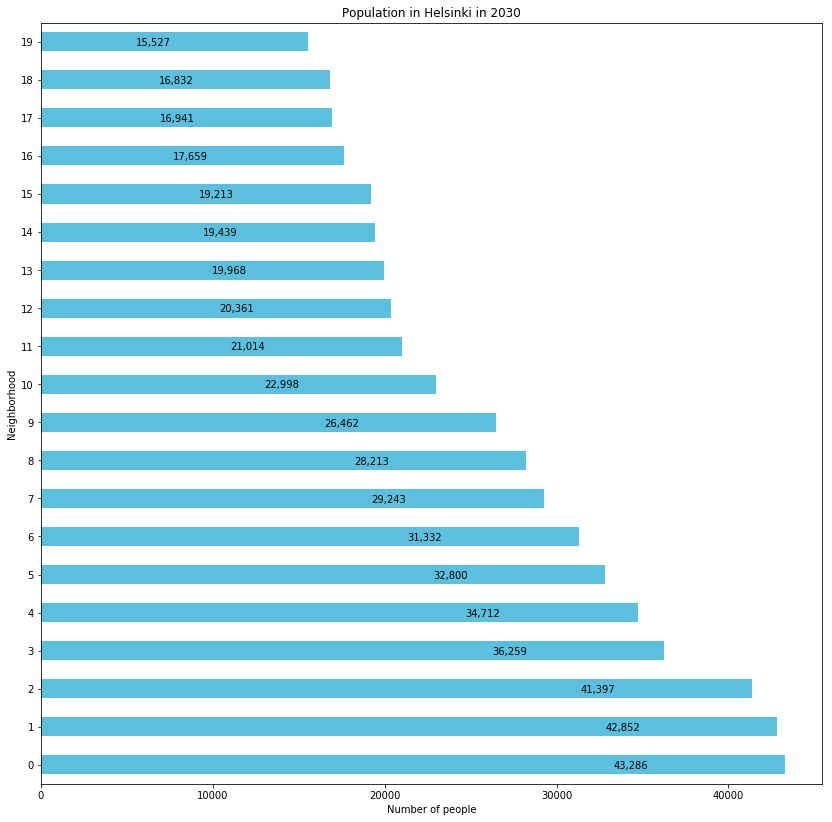

In [26]:
corr.sort_values(by='2030', ascending=False, axis=0, inplace=True)
corr['2030'].plot(kind='barh', figsize=(14, 14), color='#5bc0de')
plt.title('Population in Helsinki in 2030')
plt.ylabel('Neighborhood')
plt.xlabel('Number of people')
for index, value in enumerate(corr['2030']): 
    label = format(int(value), ',')
    plt.annotate(label, xy=(value - 10000, index - 0.10), color='black')
plt.show()



#### Helsinki map with top20 population in 2030 neighborhoods

In [27]:
# create map of Helsinki using latitude and longitude values
map_hki = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(new['lat'], new['lng'], new['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_hki) 
    

map_hki

#### Foursquare API

#### In this section we generate url for fetching venue data for Helsinki neigborhoods. The id and secret will not be shown

In [26]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

In [29]:
#Check that coordites work correctly
neighborhood_latitude = new.loc[0, 'lat'] # neighborhood latitude value
neighborhood_longitude = new.loc[0, 'lng'] # neighborhood longitude value

neighborhood_name = new.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))


Latitude and longitude values of Vuosaari are 60.2083483, 25.1435537.


#### Functions for data preparation and analysis 

In [30]:
#Function to Get nearby venues
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


In [31]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [32]:
# Function for most common venue
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### Helsinki venues

In [33]:
all_helsinki_venues = getNearbyVenues(names=new['Neighborhood'],latitudes=new['lat'], longitudes=new['lng'])

Vuosaari
Kallio
Mellunkylä
Kaarela
Malmi
Herttoniemi
Laajasalo
Vanhakaupunki
Haaga
Lauttasaari
Sörnäinen
Vartiokylä
Puistola
Pitäjänmäki
Länsisatama
Munkkiniemi
Oulunkylä
Vallila
Taka-Töölö
Pasila


In [34]:
all_helsinki_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Vuosaari,60.208348,25.143554,UH & FIX Vuosaari,60.208813,25.141487,Recreation Center
1,Vuosaari,60.208348,25.143554,Marian Konditoria,60.207007,25.145349,Bakery
2,Vuosaari,60.208348,25.143554,Vuosaaren urheilutalo,60.208787,25.141546,Gym / Fitness Center
3,Vuosaari,60.208348,25.143554,Liikuntakeskus Fressi Clubhouse,60.207059,25.135240,Gym
4,Vuosaari,60.208348,25.143554,Alko,60.206937,25.145789,Liquor Store


In [35]:
all_helsinki_venues.groupby('Neighborhood').nunique()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,,
Haaga,1,1,1,14,14,14,11
Herttoniemi,1,1,1,30,30,30,20
Kaarela,1,1,1,5,5,5,5
Kallio,1,1,1,29,30,30,21
Laajasalo,1,1,1,4,4,4,2
Lauttasaari,1,1,1,26,26,26,20
Länsisatama,1,1,1,27,27,27,22
Malmi,1,1,1,30,30,30,20
Mellunkylä,1,1,1,21,21,21,19


#### Let's find out how many unique categories can be curated from all the returned venues

In [36]:
print('There are {} uniques categories.'.format(len(all_helsinki_venues['Venue Category'].unique())))

There are 141 uniques categories.


In [37]:
# Print all unique venue groups
all_helsinki_venues['Venue Category'].unique()

array(['Recreation Center', 'Bakery', 'Gym / Fitness Center', 'Gym',
       'Liquor Store', 'Pizza Place', 'Grocery Store', 'Clothing Store',
       'Café', 'Pub', 'Jewelry Store', 'Bookstore', 'Pool', 'Plaza',
       'Thrift / Vintage Store', 'Flower Shop', 'Taxi Stand',
       'Shoe Repair', 'Playground', 'Bike Shop',
       'Scandinavian Restaurant', 'Bus Stop', 'Hotel', 'Park',
       'Supermarket', 'Thai Restaurant', 'Wine Bar', 'Breakfast Spot',
       'Sushi Restaurant', 'Middle Eastern Restaurant', 'Beer Bar',
       'Yoga Studio', 'Japanese Restaurant', 'Cafeteria', 'Theater',
       'Food & Drink Shop', 'South American Restaurant', 'Dive Bar',
       'Sauna / Steam Room', 'Himalayan Restaurant', 'Skate Park',
       'Falafel Restaurant', 'Sandwich Place', 'Chinese Restaurant',
       'Fast Food Restaurant', 'Bar', 'Food', 'Hockey Field',
       'Indian Restaurant', 'Pharmacy', 'Dance Studio', 'Garden',
       'Stables', 'Salad Place', 'Hotel Bar', 'Coffee Shop',
       'Indie

In [38]:
all_helsinki_venues.shape

(424, 7)

#### Let's check how many venues there is in each neighborhood

In [39]:
hood_venue = all_helsinki_venues[['Neighborhood', 'Venue']].copy()

In [40]:
hood_venues = hood_venue.groupby(['Neighborhood']).size().reset_index(name='Venues')
hood_venues.head()

,Neighborhood,Venues
0,Haaga,14
1,Herttoniemi,30
2,Kaarela,5
3,Kallio,30
4,Laajasalo,4


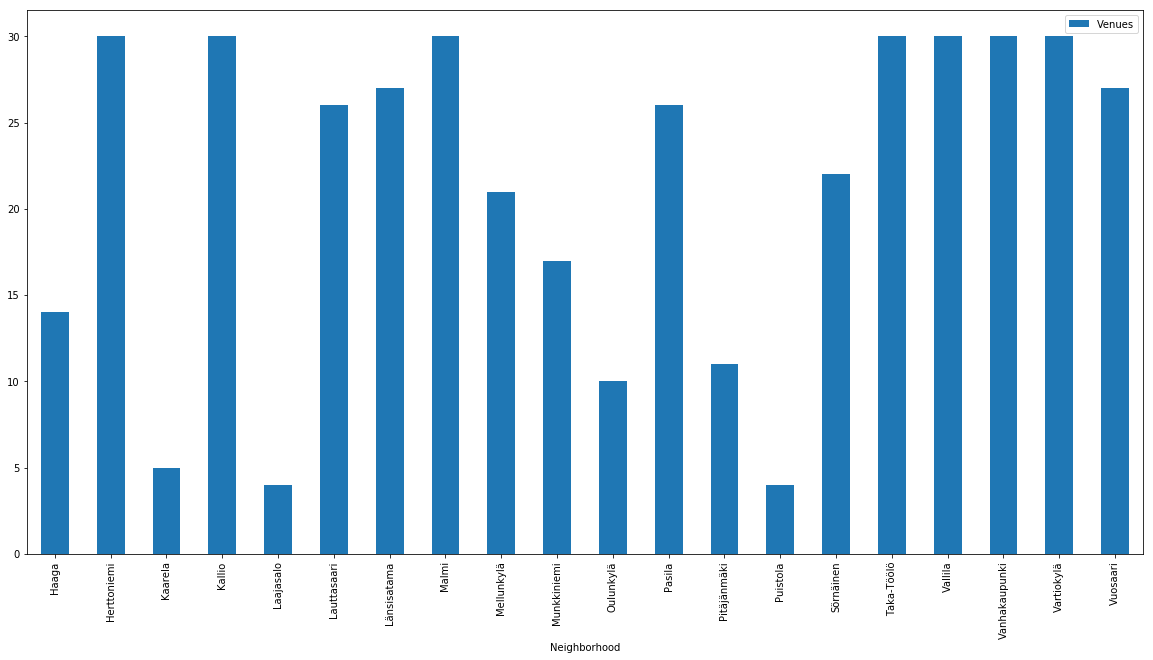

In [41]:
hood_venues.sort_values(by=['Venues'])
hood_venues.plot.bar(x='Neighborhood', y='Venues', rot=90,figsize=(20,10))

#### Analyze Each Neighborhood

In [42]:
# one hot encoding
helsinki_onehot = pd.get_dummies(all_helsinki_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
helsinki_onehot['Neighborhood'] = all_helsinki_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [helsinki_onehot.columns[-1]] + list(helsinki_onehot.columns[:-1])
downtown_onehot = helsinki_onehot[fixed_columns]

helsinki_onehot.head()

,African Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Bakery,Bar,Bay,Beach,Beer Bar,Beer Garden,Bike Shop,Bookstore,Breakfast Spot,Burger Joint,Burrito Place,Bus Stop,Business Service,Cafeteria,Café,Canal,Chinese Restaurant,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Construction & Landscaping,Convenience Store,Costume Shop,Dance Studio,Department Store,Dessert Shop,Disc Golf,Discount Store,Dive Bar,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Fast Food Restaurant,Flea Market,Flower Shop,Food,Food & Drink Shop,Furniture / Home Store,Garden,Gastropub,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Health Food Store,Hill,Himalayan Restaurant,Historic Site,History Museum,Hockey Field,Hostel,Hotel,Hotel Bar,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Kebab Restaurant,Knitting Store,Kurdish Restaurant,Laundry Service,Liquor Store,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Mountain,Movie Theater,Multiplex,Museum,Music School,Music Venue,Neighborhood,Organic Grocery,Outdoor Sculpture,Outdoor Supply Store,Park,Pet Store,Pharmacy,Pizza Place,Platform,Playground,Plaza,Pool,Post Office,Pub,Record Shop,Recreation Center,Restaurant,Road,Roof Deck,Salad Place,Sandwich Place,Sauna / Steam Room,Scandinavian Restaurant,Scenic Lookout,Shoe Repair,Shopping Mall,Skate Park,Soccer Field,Soccer Stadium,South American Restaurant,Sporting Goods Shop,Stables,Supermarket,Sushi Restaurant,Taxi Stand,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Train Station,Tram Station,Tunnel,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Warehouse Store,Waterfront,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Vuosaari,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Vuosaari,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Vuosaari,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Vuosaari,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,Vuosaari,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [43]:
helsinki_grouped = helsinki_onehot.groupby('Neighborhood').mean().reset_index()
helsinki_grouped.head()

,Neighborhood,African Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Bakery,Bar,Bay,Beach,Beer Bar,Beer Garden,Bike Shop,Bookstore,Breakfast Spot,Burger Joint,Burrito Place,Bus Stop,Business Service,Cafeteria,Café,Canal,Chinese Restaurant,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Construction & Landscaping,Convenience Store,Costume Shop,Dance Studio,Department Store,Dessert Shop,Disc Golf,Discount Store,Dive Bar,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Fast Food Restaurant,Flea Market,Flower Shop,Food,Food & Drink Shop,Furniture / Home Store,Garden,Gastropub,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Health Food Store,Hill,Himalayan Restaurant,Historic Site,History Museum,Hockey Field,Hostel,Hotel,Hotel Bar,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Kebab Restaurant,Knitting Store,Kurdish Restaurant,Laundry Service,Liquor Store,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Mountain,Movie Theater,Multiplex,Museum,Music School,Music Venue,Organic Grocery,Outdoor Sculpture,Outdoor Supply Store,Park,Pet Store,Pharmacy,Pizza Place,Platform,Playground,Plaza,Pool,Post Office,Pub,Record Shop,Recreation Center,Restaurant,Road,Roof Deck,Salad Place,Sandwich Place,Sauna / Steam Room,Scandinavian Restaurant,Scenic Lookout,Shoe Repair,Shopping Mall,Skate Park,Soccer Field,Soccer Stadium,South American Restaurant,Sporting Goods Shop,Stables,Supermarket,Sushi Restaurant,Taxi Stand,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Train Station,Tram Station,Tunnel,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Warehouse Store,Waterfront,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo
0,Haaga,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.214286,0.0,0.000000,0.071429,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.071429,0.000000,0.071429,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.071429,0.0,0.000000,0.071429,0.142857,0.0,0.0,0.0,0.000000,0.0,0.0,0.071429,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.071429,0.0,0.000000,0.0,0.0,0.071429,0.071429,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
1,Herttoniemi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.033333,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.200000,0.0,0.000000,0.000000,0.0,0.033333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.0,0.033333,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.033333,0.033333,0.033333,0.0,0.100000,0.0,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.0,0.033333,0.0,0.0,0.000000,0.0,0.033333,0.0,0.0,0.033333,0.033333,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.066667,0.000000,0.000000,0.0,0.0,0.0,0.033333,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.066667,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.066667,0.033333,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
2,Kaarela,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.200000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.2,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.200000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.200000,0.0,0.0000

In [44]:
#Get 10 top venues of neighborhood
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = helsinki_grouped['Neighborhood']

for ind in np.arange(helsinki_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(helsinki_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Haaga,Bus Stop,Platform,Recreation Center,Grocery Store,Pizza Place,Park,Café,Soccer Field,Sushi Restaurant,Garden
1,Herttoniemi,Bus Stop,Gym / Fitness Center,Pharmacy,Sandwich Place,Supermarket,Intersection,Post Office,Convenience Store,Chinese Restaurant,Garden
2,Kaarela,Dance Studio,Park,Stables,Garden,Bus Stop,Ethiopian Restaurant,Event Space,Falafel Restaurant,Fast Food Restaurant,Dessert Shop
3,Kallio,Bakery,Café,Park,Scandinavian Restaurant,Breakfast Spot,Japanese Restaurant,Theater,Dive Bar,Food & Drink Shop,Sauna / Steam Room
4,Laajasalo,Bus Stop,Park,Flea Market,Garden,Furniture / Home Store,Food & Drink Shop,Food,Flower Shop,Zoo,Gastropub


In [45]:
#Check shape
helsinki_grouped.shape

(20, 141)

In [46]:
all_helsinki_venues.shape

(424, 7)

#### Let's print each neighborhood along with the top 5 most common venues 

In [47]:
#Five top venues of Helsinki neighborhoods
num_top_venues = 5

for hood in new['Neighborhood']:
    print("----"+hood+"----")
    temp = helsinki_grouped[helsinki_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Vuosaari----
            venue  freq
0            Café  0.07
1     Pizza Place  0.07
2  Clothing Store  0.07
3      Playground  0.07
4             Pub  0.04


----Kallio----
                     venue  freq
0                   Bakery  0.17
1                     Café  0.10
2                     Park  0.07
3  Scandinavian Restaurant  0.07
4           Breakfast Spot  0.07


----Mellunkylä----
                  venue  freq
0                   Bar  0.10
1  Gym / Fitness Center  0.10
2      Sushi Restaurant  0.05
3          Hockey Field  0.05
4                  Food  0.05


----Kaarela----
          venue  freq
0      Bus Stop   0.2
1          Park   0.2
2       Stables   0.2
3  Dance Studio   0.2
4        Garden   0.2


----Malmi----
                    venue  freq
0                Wine Bar  0.13
1             Coffee Shop  0.10
2                   Hotel  0.10
3                    Café  0.07
4  Furniture / Home Store  0.07


----Herttoniemi----
                  venue  freq
0            

#### Cluster Neighborhoods 

#### Run k-means to cluster the neighborhood into 5 clusters

In [48]:
# set number of clusters
kclusters = 5

helsinki_grouped_clustering = helsinki_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(helsinki_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 3, 3, 1, 2, 1, 1, 1, 1, 1], dtype=int32)

#### Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood

In [49]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

helsinki_merged = all_helsinki_venues

# merge helsinki_grouped with helsinki_data to add latitude/longitude for each neighborhood
helsinki_merged = helsinki_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

helsinki_merged.head() 

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Vuosaari,60.208348,25.143554,UH & FIX Vuosaari,60.208813,25.141487,Recreation Center,1,Pizza Place,Playground,Clothing Store,Café,Liquor Store,Gym,Grocery Store,Flower Shop,Bus Stop,Gym / Fitness Center
1,Vuosaari,60.208348,25.143554,Marian Konditoria,60.207007,25.145349,Bakery,1,Pizza Place,Playground,Clothing Store,Café,Liquor Store,Gym,Grocery Store,Flower Shop,Bus Stop,Gym / Fitness Center
2,Vuosaari,60.208348,25.143554,Vuosaaren urheilutalo,60.208787,25.141546,Gym / Fitness Center,1,Pizza Place,Playground,Clothing Store,Café,Liquor Store,Gym,Grocery Store,Flower Shop,Bus Stop,Gym / Fitness Center
3,Vuosaari,60.208348,25.143554,Liikuntakeskus Fressi Clubhouse,60.207059,25.135240,Gym,1,Pizza Place,Playground,Clothing Store,Café,Liquor Store,Gym,Grocery Store,Flower Shop,Bus Stop,Gym / Fitness Center
4,Vuosaari,60.208348,25.143554,Alko,60.206937,25.145789,Liquor Store,1,Pizza Place,Playground,Clothing Store,Café,Liquor Store,Gym,Grocery Store,Flower Shop,Bus Stop,Gym / Fitness Center


#### Let's visualize the resulting clusters

In [50]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(helsinki_merged['Neighborhood Latitude'], helsinki_merged['Neighborhood Longitude'], helsinki_merged['Neighborhood'], helsinki_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [51]:
most_common_in_cluster = helsinki_merged[['Cluster Labels', '1st Most Common Venue']].copy()
most_common_in_cluster = most_common_in_cluster.groupby(['Cluster Labels', '1st Most Common Venue' ]).size().reset_index(name='Venues')
most_common_in_cluster

,Cluster Labels,1st Most Common Venue,Venues
0,0,Mobile Phone Shop,11
1,1,Art Gallery,27
2,1,Bakery,30
3,1,Café,17
4,1,Coffee Shop,56
5,1,Gym / Fitness Center,21
6,1,Historic Site,30
7,1,Park,30
8,1,Pizza Place,79
9,1,Supermarket,26


In [52]:
#Giving cluster names after analyzing data
cluster_name = {}
cluster_name[0] = "Lot of services"
cluster_name[1] = "Vine & Dine"
cluster_name[2] = "Traffic spot"
cluster_name[3] = "Park"
cluster_name[4] = "Shopping Mall"

In [53]:
helsinki_merged.set_index("Neighborhood", inplace=True)
helsinki_merged.head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Neighborhood,,,,,,,,,,,,,,,,,
Vuosaari,60.208348,25.143554,UH & FIX Vuosaari,60.208813,25.141487,Recreation Center,1,Pizza Place,Playground,Clothing Store,Café,Liquor Store,Gym,Grocery Store,Flower Shop,Bus Stop,Gym / Fitness Center
Vuosaari,60.208348,25.143554,Marian Konditoria,60.207007,25.145349,Bakery,1,Pizza Place,Playground,Clothing Store,Café,Liquor Store,Gym,Grocery Store,Flower Shop,Bus Stop,Gym / Fitness Center
Vuosaari,60.208348,25.143554,Vuosaaren urheilutalo,60.208787,25.141546,Gym / Fitness Center,1,Pizza Place,Playground,Clothing Store,Café,Liquor Store,Gym,Grocery Store,Flower Shop,Bus Stop,Gym / Fitness Center
Vuosaari,60.208348,25.143554,Liikuntakeskus Fressi Clubhouse,60.207059,25.135240,Gym,1,Pizza Place,Playground,Clothing Store,Café,Liquor Store,Gym,Grocery Store,Flower Shop,Bus Stop,Gym / Fitness Center
Vuosaari,60.208348,25.143554,Alko,60.206937,25.145789,Liquor Store,1,Pizza Place,Playground,Clothing Store,Café,Liquor Store,Gym,Grocery Store,Flower Shop,Bus Stop,Gym / Fitness Center


#### Example of how an investor could study information of a neighborhood when thinking about of any kind of a business idea 

In [54]:
helsinki_merged.loc['Kallio'].head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Neighborhood,,,,,,,,,,,,,,,,,
Kallio,60.183982,24.952451,Karhupuisto,60.183919,24.952487,Park,1,Bakery,Café,Park,Scandinavian Restaurant,Breakfast Spot,Japanese Restaurant,Theater,Dive Bar,Food & Drink Shop,Sauna / Steam Room
Kallio,60.183982,24.952451,IPI Kulmakuppila,60.183200,24.953525,Café,1,Bakery,Café,Park,Scandinavian Restaurant,Breakfast Spot,Japanese Restaurant,Theater,Dive Bar,Food & Drink Shop,Sauna / Steam Room
Kallio,60.183982,24.952451,Ravintola Kolmon3n,60.182188,24.950142,Scandinavian Restaurant,1,Bakery,Café,Park,Scandinavian Restaurant,Breakfast Spot,Japanese Restaurant,Theater,Dive Bar,Food & Drink Shop,Sauna / Steam Room
Kallio,60.183982,24.952451,Lidl,60.182164,24.953236,Supermarket,1,Bakery,Café,Park,Scandinavian Restaurant,Breakfast Spot,Japanese Restaurant,Theater,Dive Bar,Food & Drink Shop,Sauna / Steam Room
Kallio,60.183982,24.952451,Way Bakery And Wine Bar,60.184383,24.954023,Bakery,1,Bakery,Café,Park,Scandinavian Restaurant,Breakfast Spot,Japanese Restaurant,Theater,Dive Bar,Food & Drink Shop,Sauna / Steam Room


#### Sort the values by cluster labels

In [55]:
helsinki_merged.sort_values(by=['Cluster Labels'], inplace=True, ascending=False)
lop=helsinki_merged.head(30)
lop

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Neighborhood,,,,,,,,,,,,,,,,,
Puistola,60.276033,25.036777,A-Hana,60.275537,25.030982,Bar,4,Bar,Gym / Fitness Center,Pizza Place,Bus Stop,Flea Market,Garden,Furniture / Home Store,Food & Drink Shop,Food,Flower Shop
Puistola,60.276033,25.036777,HSL 3343 Maatullinaukio,60.274954,25.035357,Bus Stop,4,Bar,Gym / Fitness Center,Pizza Place,Bus Stop,Flea Market,Garden,Furniture / Home Store,Food & Drink Shop,Food,Flower Shop
Oulunkylä,60.229443,24.963583,Capperi,60.231190,24.968003,Pizza Place,4,Pizza Place,Bus Stop,Recreation Center,Grocery Store,Park,Irish Pub,Knitting Store,Hotel,Food & Drink Shop,Disc Golf
Oulunkylä,60.229443,24.963583,K-market Pikkupekka,60.232506,24.957560,Grocery Store,4,Pizza Place,Bus Stop,Recreation Center,Grocery Store,Park,Irish Pub,Knitting Store,Hotel,Food & Drink Shop,Disc Golf
Oulunkylä,60.229443,24.963583,Oulunkylän Kebab-Pizzeria,60.230040,24.964980,Pizza Place,4,Pizza Place,Bus Stop,Recreation Center,Grocery Store,Park,Irish Pub,Knitting Store,Hotel,Food & Drink Shop,Disc Golf
Oulunkylä,60.229443,24.963583,Oulunkylän liikuntapuisto,60.233676,24.961023,Recreation Center,4,Pizza Place,Bus Stop,Recreation Center,Grocery Store,Park,Irish Pub,Knitting Store,Hotel,Food & Drink Shop,Disc Golf
Oulunkylä,60.229443,24.963583,Lankamaailma,60.228359,24.963601,Knitting Store,4,Pizza Place,Bus Stop,Recreation Center,Grocery Store,Park,Irish Pub,Knitting Store,Hotel,Food & Drink Shop,Disc Golf
Oulunkylä,60.229443,24.963583,O'Gelis Bar,60.229565,24.968075,Irish Pub,4,Pizza Place,Bus Stop,Recreation Center,Grocery Store,Park,Irish Pub,Knitting Store,Hotel,Food & Drink Shop,Disc Golf
Oulunkylä,60.229443,24.963583,Kotipizza,60.231087,24.968137,Pizza Place,4,Pizza Place,Bus Stop,Recreation Center,Grocery Store,Park,Irish Pub,Knitting Store,Hotel,Food & Drink Shop,Disc Golf


#### Identify and count the competing venues

In [56]:
lop2=all_helsinki_venues
competitions = ['estaurant']
pattern = '|'.join(competitions)
lop2['Competitors'] = lop2['Venue Category'].str.contains(pattern, case=False)
competitors = lop2[['Neighborhood', 'Competitors']]
competitors[competitors['Neighborhood'] == True].groupby('Neighborhood').sum()
comb = competitors.groupby('Neighborhood').sum()
comb[['Competitors']].astype('int')
pd.set_eng_float_format(accuracy=0, use_eng_prefix=True)
comb

,Competitors
Neighborhood,
Haaga,1
Herttoniemi,4
Kaarela,0
Kallio,7
Laajasalo,0
Lauttasaari,4
Länsisatama,4
Malmi,4
Mellunkylä,7


In [57]:
lopp1 = pd.merge(corr, comb, on='Neighborhood')
lopp1.head()

,Neighborhood,lat,lng,2019,2030,percent,Growth,Competitors
0,Vuosaari,60,25,38823,43286,1,4463,1
1,Kallio,60,25,29934,42852,1,12918,7
2,Mellunkylä,60,25,39167,41397,1,2230,7
3,Kaarela,60,25,28874,36259,1,7385,0
4,Malmi,56,13,29374,34712,1,5338,4


In [58]:
lopp1.drop(['lat', 'lng', '2019', 'percent'], axis=1, inplace=True)
lopp1['Customers/Venue'] = lopp1['2030'] / lopp1['Competitors']
lopp1

,Neighborhood,2030,Growth,Competitors,Customers/Venue
0,Vuosaari,43286,4463,1,43k
1,Kallio,42852,12918,7,6k
2,Mellunkylä,41397,2230,7,6k
3,Kaarela,36259,7385,0,inf
4,Malmi,34712,5338,4,9k
5,Herttoniemi,32800,3916,4,8k
6,Laajasalo,31332,11317,0,inf
7,Vanhakaupunki,29243,3823,6,5k
8,Haaga,28213,531,1,28k
9,Lauttasaari,26462,2068,4,7k


In [60]:
def func(lopp1):
    if lopp1['Competitors'] > 5: val = 'Too many competitors'
    elif lopp1['Customers/Venue'] < 3000: val = 'No customer base'
    elif lopp1['Growth'] > 10000: val = 'Best location'
    else: val = 'Potential location'
    return val

In [61]:
lopp1['Assessment'] = lopp1.apply(func, axis=1)
lopp1

,Neighborhood,2030,Growth,Competitors,Customers/Venue,Assessment
0,Vuosaari,43286,4463,1,43k,Potential location
1,Kallio,42852,12918,7,6k,Too many competitors
2,Mellunkylä,41397,2230,7,6k,Too many competitors
3,Kaarela,36259,7385,0,inf,Potential location
4,Malmi,34712,5338,4,9k,Potential location
5,Herttoniemi,32800,3916,4,8k,Potential location
6,Laajasalo,31332,11317,0,inf,Best location
7,Vanhakaupunki,29243,3823,6,5k,Too many competitors
8,Haaga,28213,531,1,28k,Potential location
9,Lauttasaari,26462,2068,4,7k,Potential location


The analysis is ready!

## Results

Helsinki has ca. 650000 habitants and the surrounding municipalities in the Helsinki region have about 1.5 million inhabitants. A very large number of those work in Helsinki and they are a good addition to Helsinki neighborhood customers.

Helsinki neighborhoods are relatively small populated. The population difference is big between neighborhoods in 2030. That is why only the largest increases and biggest neighborhood population were taken into account. 

There were 138 unique venues. I grouped rows by neighborhood and by taking the mean of the frequency of occurrence of each category.

I checked each neighborhood along with the top 5 most common venues.

I also checked how many venues there are in each venue. 

The clustering is presented in a map.

And finally I identified and counted the competing venues and the results are presented in a table. 


## Discussion

Helsinki City is a relatively small city so for effective data analysis we would need even more venues in Foursquare. Lot of neighborhoods have small amount of many kind of venues to offer (most of them were restaurants). With adjusting k-means clustering we could have even better results.

When the number of venues has greatly increased, the result of this type of analysis is more reliable.

I also know in which neighborhoods there is significant construction output. I would suggest a couple of other neighborhoods are worth considering when starting a new restaurant business in Helsinki. Those can be seen in tables in this analysis.

## Conclusions

This kind of data analysis can be a helpful for any investor who is planning to start a business. It provides competitive advance quite quickly.

The decision should not be made on the basis of this study alone. The results are always indicative only. You should also go on site to ensure that the environment also meets expectations. Also no one yet knows how COVID-19 will affect the future.